#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 15
**CH15A Predicting used car value with regression trees**

using the used-cars dataset

version 0.91 2021-01-19

In [5]:
import os
import random
import sys
import warnings
from collections import Counter
from io import StringIO

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import Image, display
from mizani.formatters import percent_format
from patsy import dmatrices
from plotnine import *
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

warnings.filterwarnings("ignore")


In [6]:
# DATA IMPORT
data = pd.read_csv("/workspaces/codespaces-jupyter/data/used-cars_2cities_prep.csv")
#data = pd.read_csv("https://osf.io/7gvz9/download")


In [7]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")


In [8]:
data["condition"].value_counts()

condition
excellent    139
good         114
like new      55
fair          15
new            4
Name: count, dtype: int64

In [9]:
data["condition"] = data["condition"].fillna("good")

In [10]:
data["condition"].value_counts()

condition
good         336
excellent    139
like new      55
fair          15
new            4
Name: count, dtype: int64

In [11]:
data.columns

Index(['pricestr', 'area', 'subarea', 'name', 'condition', 'cylinders',
       'drive', 'fuel', 'odometer', 'paintcolor', 'size', 'transmission',
       'type', 'dealer', 'price', 'lnprice', 'year', 'age', 'lnodometer', 'LE',
       'XLE', 'SE', 'Hybrid'],
      dtype='object')

In [12]:
data["transmission"].value_counts()

transmission
automatic    538
manual         9
other          2
Name: count, dtype: int64

In [13]:
data["fuel"].value_counts()

fuel
gas        526
hybrid      14
other        7
Missing      1
diesel       1
Name: count, dtype: int64

In [14]:
# keep gas-fuelled vehicles
data = data.query("fuel=='gas'")

# drop vehicles in fair and new condition, trucks
data = data.query("condition not in ['new','fair']")

# drop unrealistic values for price and odometer reading
price_range = list(range(500, 25001, 1))
data = data.query("price in @price_range").query("odometer<=100")

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.query("~(price < 1000 & (condition == 'like new'|age < 8))")

data = data.query("~(transmission=='manual')")

# drop if truck
data = data.query("type not in ['truck','pickup']")

# drop pricestr
data = data.drop(["pricestr"], axis=1)


In [15]:
# to be on the safe side
data = data[data["price"].notna()]
data = data.reset_index()


In [16]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# chicago
data["chicago"] = np.where(data["area"] == "chicago", 1, 0)
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3
data.to_csv("usedcars_work.csv", index=False)


In [17]:
data.price.describe()

count      487.000000
mean      5871.143737
std       4321.192160
min        500.000000
25%       2500.000000
50%       4500.000000
75%       8300.000000
max      18500.000000
Name: price, dtype: float64

In [18]:
smp_size = np.floor(0.7 * data.shape[0])

In [19]:
# Initialize random seed to make it reproducible
random.seed(42)
train_ids = random.sample(range(0, data.shape[0]), int(smp_size))

data["train"] = 0
data["train"][train_ids] = 1

In [20]:
data

,index,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,Hybrid,cond_excellent,cond_good,cond_likenew,cylind6,chicago,agesq,agecu,odometersq,train
0,0,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.623600,grey,...,1,0,1,0,0,1,121,1331,1570.442243,1
1,2,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,Missing,gas,3.572100,NaN,...,0,1,0,0,0,1,9,27,45.579633,1
2,3,chicago,chicago city,2016 TOYOTA CAMRY,good,Missing,fwd,gas,1.315200,NaN,...,0,0,1,0,0,1,4,8,2.274969,0
3,4,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,...,0,0,1,0,1,1,625,15625,6539.203000,1
4,6,chicago,chicago city,1998 toyota camry le,good,Missing,Missing,gas,16.824259,NaN,...,0,0,1,0,0,1,400,8000,4762.202089,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,543,los angeles,North LA county,2001 toyota camry,excellent,6 cylinders,Missing,gas,27.000000,NaN,...,0,1,0,0,1,0,289,4913,19683.000000,1
483,545,los angeles,central LA,2012 toyota camry se,excellent,4 cylinders,Missing,gas,8.304974,NaN,...,0,1,0,0,0,0,36,216,572.815510,1
484,546,los angeles,central LA,2008 TOYOTA CAMRY,good,Missing,Missing,gas,12.548112,NaN,...,0,0,1,0,0,0,100,1000,1975.764375,1
485,547,los angeles,San Fernando,2002 toyota camry,excellent,4 cylinders,Missing,gas,16.100000,NaN,...,0,1,0,0,0,0,256,4096,4173.281000,1


In [21]:
# Initialize random seed to make it reproducible
random.seed(42)
train_ids = random.sample(range(0, data.shape[0]), int(smp_size))

data["train"] = 0
data["train"][train_ids] = 1

In [22]:
data["train"].value_counts()

train
1    340
0    147
Name: count, dtype: int64

In [23]:
data_train = data.query("train==1")
data_test = data.query("train==0")

In [24]:
data_train.describe()

,index,odometer,dealer,price,lnprice,year,age,lnodometer,LE,XLE,...,Hybrid,cond_excellent,cond_good,cond_likenew,cylind6,chicago,agesq,agecu,odometersq,train
count,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,...,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.0
mean,278.723529,12.834365,0.205882,5736.158824,8.368309,2005.723529,12.276471,2.432025,0.202941,0.082353,...,0.023529,0.273529,0.620588,0.105882,0.129412,0.570588,183.505882,3077.641176,3246.382275,1.0
std,160.905751,5.355802,0.404941,4218.153638,0.796764,5.735058,5.735058,0.556719,0.402782,0.275307,...,0.151801,0.446427,0.485956,0.308140,0.336150,0.495722,149.382811,3548.804918,4261.117446,0.0
min,0.000000,0.500000,0.000000,500.000000,6.214608,1991.000000,1.000000,-0.693147,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.125000,1.0
25%,133.750000,9.616325,0.000000,2500.000000,7.824046,2002.000000,8.000000,2.262900,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64.000000,512.000000,892.139827,1.0
50%,284.000000,13.727950,0.000000,4400.000000,8.389359,2006.000000,12.000000,2.619420,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,144.000000,1728.000000,2587.336729,1.0
75%,413.250000,16.405325,0.000000,7600.000000,8.935904,2010.000000,16.000000,2.797606,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,256.000000,4096.000000,4415.246219,1.0
max,548.000000,37.000000,1.000000,18500.000000,9.825526,2017.000000,27.000000,3.610918,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,729.000000,19683.000000,50653.000000,1.0


### Regression tree
---

## One split

In [25]:
cart1 = DecisionTreeRegressor(random_state=42, max_depth=1)

# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart1.fit(X, Y)


DecisionTreeRegressor(max_depth=1, random_state=42)

In [26]:
pred_cart1 = cart1.predict(data_test[["age"]])
rmse_cart1 = np.sqrt(mean_squared_error(data_test["price"], pred_cart1))

In [27]:
pred_cart1

array([11655.6       ,  3914.79230769,  3914.79230769,  3914.79230769,
        3914.79230769,  3914.79230769,  3914.79230769,  3914.79230769,
        3914.79230769,  3914.79230769, 11655.6       ,  3914.79230769,
        3914.79230769,  3914.79230769,  3914.79230769,  3914.79230769,
        3914.79230769,  3914.79230769, 11655.6       ,  3914.79230769,
        3914.79230769,  3914.79230769, 11655.6       ,  3914.79230769,
        3914.79230769,  3914.79230769,  3914.79230769, 11655.6       ,
        3914.79230769, 11655.6       , 11655.6       ,  3914.79230769,
        3914.79230769, 11655.6       ,  3914.79230769,  3914.79230769,
        3914.79230769,  3914.79230769,  3914.79230769,  3914.79230769,
       11655.6       , 11655.6       , 11655.6       , 11655.6       ,
       11655.6       ,  3914.79230769, 11655.6       , 11655.6       ,
       11655.6       ,  3914.79230769,  3914.79230769,  3914.79230769,
        3914.79230769,  3914.79230769,  3914.79230769, 11655.6       ,
      

In [28]:
rmse_cart1

np.float64(2665.4142827747787)

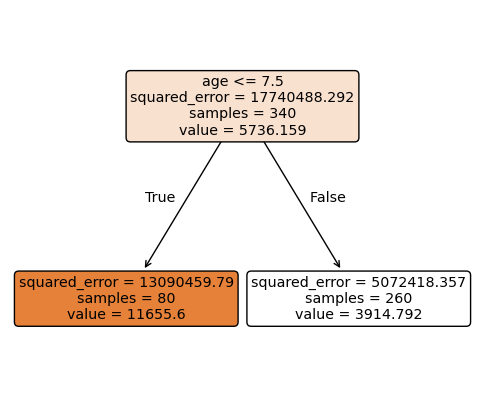

In [29]:
plt.figure(figsize=(6, 5))
plot_tree(cart1, feature_names=["age"], filled=True, rounded=True)
plt.show()

In [30]:
### Scatterplot with step function
plot_helper = np.arange(min(data_train["age"]), max(data_train["age"]), step=1)

plot_helper_df = pd.DataFrame({"age": plot_helper})
plot_helper_df["xend"] = pd.Series(plot_helper) + 1
plot_helper_df["yend"] = cart1.predict(plot_helper_df[["age"]])
pred_cart1t = cart1.predict(data_train[["age"]])


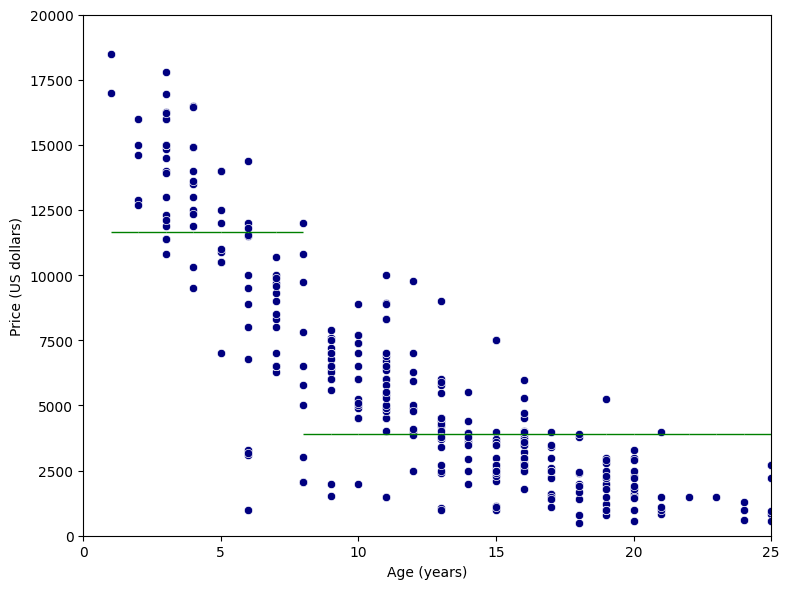

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_train, x="age", y="price", color="navy")

for _, row in plot_helper_df.iterrows():
    plt.hlines(
        y=row["yend"],
        xmin=row["age"],
        xmax=row["xend"],
        color="green",
        linewidth=1,
    )

plt.ylim(0, 20000)
plt.xlim(0, 25)
plt.yticks(np.arange(0, 20001, 2500))
plt.xticks(np.arange(0, 26, 5))
plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.grid(False)
plt.tight_layout()
plt.show()


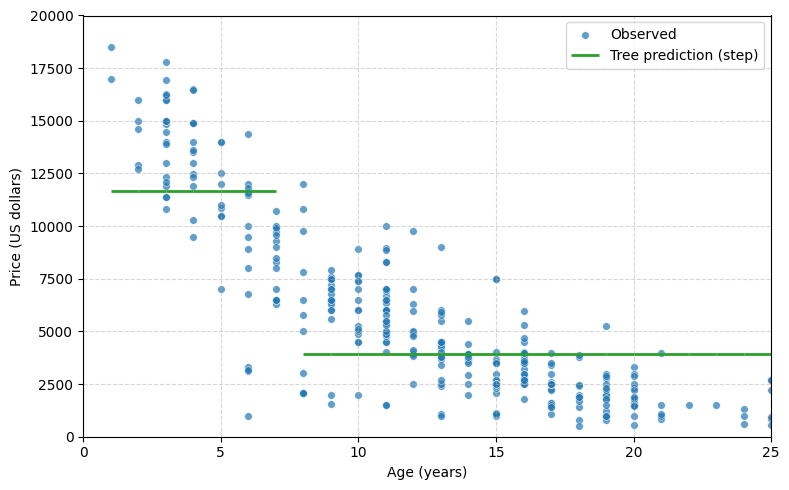

In [32]:
# Seaborn/Matplotlib plot with gaps (no linking lines between steps)
ages = np.arange(data_train["age"].min(), data_train["age"].max() + 1)
preds = cart1.predict(ages.reshape(-1, 1))

plt.figure(figsize=(8, 5))
sns.scatterplot(x="age", y="price", data=data_train, color="tab:blue", s=30, alpha=0.7, label="Observed")

# Plot horizontal lines for each segment, with gaps at splits
for i in range(len(ages) - 1):
    if preds[i] == preds[i + 1]:
        plt.hlines(preds[i], ages[i], ages[i + 1], color="tab:green", linewidth=2, label="Tree prediction (step)" if i == 0 else "")
    else:
        plt.hlines(preds[i], ages[i], ages[i], color="tab:green", linewidth=2)  # just a point, creates a gap

plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.ylim(0, 20000)
plt.xlim(0, 25)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Splits at two levels
#### (make sure it stops by setting "max_depth" to 2)

In [33]:
cart2 = DecisionTreeRegressor(random_state=2018, max_depth=2)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart2.fit(X, Y)


DecisionTreeRegressor(max_depth=2, random_state=2018)

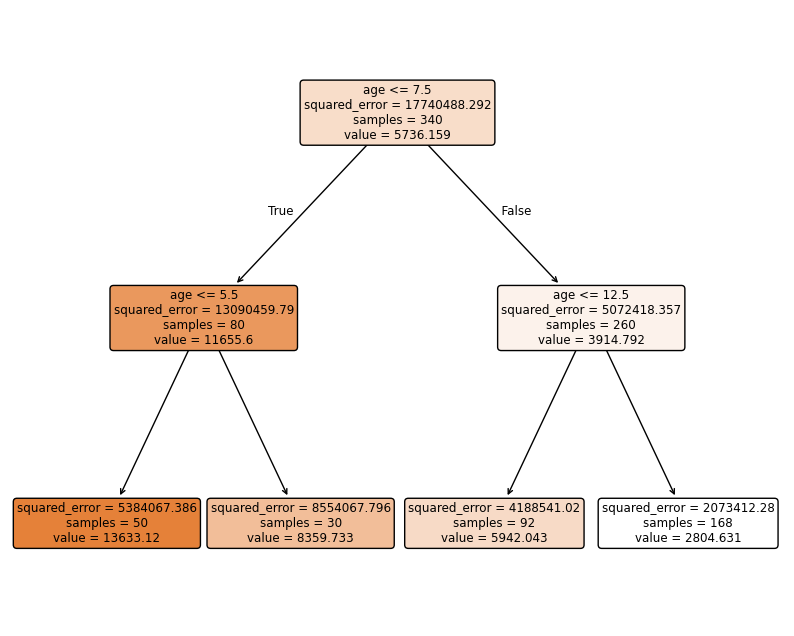

In [34]:
plt.figure(figsize=(10, 8))
plot_tree(cart2, feature_names=["age"], filled=True, rounded=True)
plt.show()

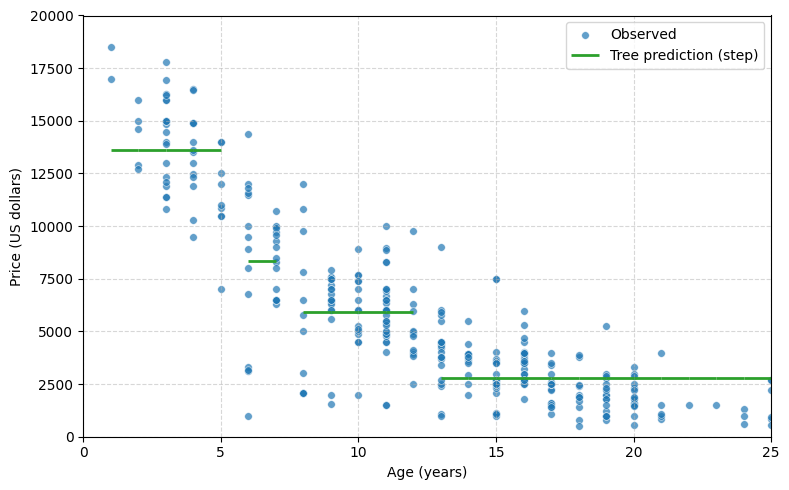

In [35]:
# Seaborn/Matplotlib plot with gaps (no linking lines between steps)
ages = np.arange(data_train["age"].min(), data_train["age"].max() + 1)
preds = cart2.predict(ages.reshape(-1, 1))

plt.figure(figsize=(8, 5))
sns.scatterplot(x="age", y="price", data=data_train, color="tab:blue", s=30, alpha=0.7, label="Observed")

# Plot horizontal lines for each segment, with gaps at splits
for i in range(len(ages) - 1):
    if preds[i] == preds[i + 1]:
        plt.hlines(preds[i], ages[i], ages[i + 1], color="tab:green", linewidth=2, label="Tree prediction (step)" if i == 0 else "")
    else:
        plt.hlines(preds[i], ages[i], ages[i], color="tab:green", linewidth=2)  # just a point, creates a gap

plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.ylim(0, 20000)
plt.xlim(0, 25)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [36]:
# Cut points
cuts = cart2.tree_.threshold[cart2.tree_.threshold != -2]

# Groups
groups = [0]
for x in cuts:
    groups += [int(np.floor(x)), int(np.floor(x) + 1)]

groups = sorted(groups) + ["or more"]


In [37]:
cuts = cart2.tree_.threshold[cart2.tree_.threshold != -2]
cuts

array([ 7.5,  5.5, 12.5])

In [38]:
print(set(cart2.tree_.threshold))

{np.float64(12.5), np.float64(5.5), np.float64(-2.0), np.float64(7.5)}


In [39]:
# get the leaf for each training sample
leaves_index = cart2.apply(X)

# use Counter to find the number of elements on each leaf
cnt = Counter(sorted(leaves_index))

# and now you can index each input to get the number of elements
elems = [cnt[x] for x in leaves_index]


In [40]:
counts = list(cnt.values())

In [41]:
av_price = (
    pd.DataFrame({"index": leaves_index, "fit": cart2.predict(X)})
    .drop_duplicates()
    .sort_values("index")["fit"]
    .tolist()
)

In [42]:
pd.DataFrame(
    {
        "Category": [
            y
            for x, y in enumerate(
                [
                    "Age " + str(groups[i]) + "-" + str(groups[i + 1])
                    for i in range(len(groups) - 1)
                ]
            )
            if x % 2 == 0
        ],
        "Count": counts,
        "Average_price": av_price,
    }
)

,Category,Count,Average_price
0,Age 0-5,50,13633.120000
1,Age 6-7,30,8359.733333
2,Age 8-12,92,5942.043478
3,Age 13-or more,168,2804.630952


In [43]:
data_train.loc[(data_train.age > 1) & (data_train.age < 12), :].shape

(157, 32)

In [44]:
pred_cart2 = cart2.predict(data_test[["age"]])
rmse_cart2 = np.sqrt(mean_squared_error(data_test["price"], pred_cart2))

**Note**: min_impurity_decrease in sklearn is considered to be the same as cp in caret, the actual values are different but the purpose is the same

In [45]:
cart3 = DecisionTreeRegressor(random_state=2018, criterion="squared_error", min_impurity_decrease=50000)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart3.fit(X, Y)

DecisionTreeRegressor(min_impurity_decrease=50000, random_state=2018)

In [46]:
pred_cart3 = cart3.predict(data_test[["age"]])

rmse_cart3 = np.sqrt(mean_squared_error(data_test["price"], pred_cart3))
rmse_cart3

np.float64(1885.9195464950155)

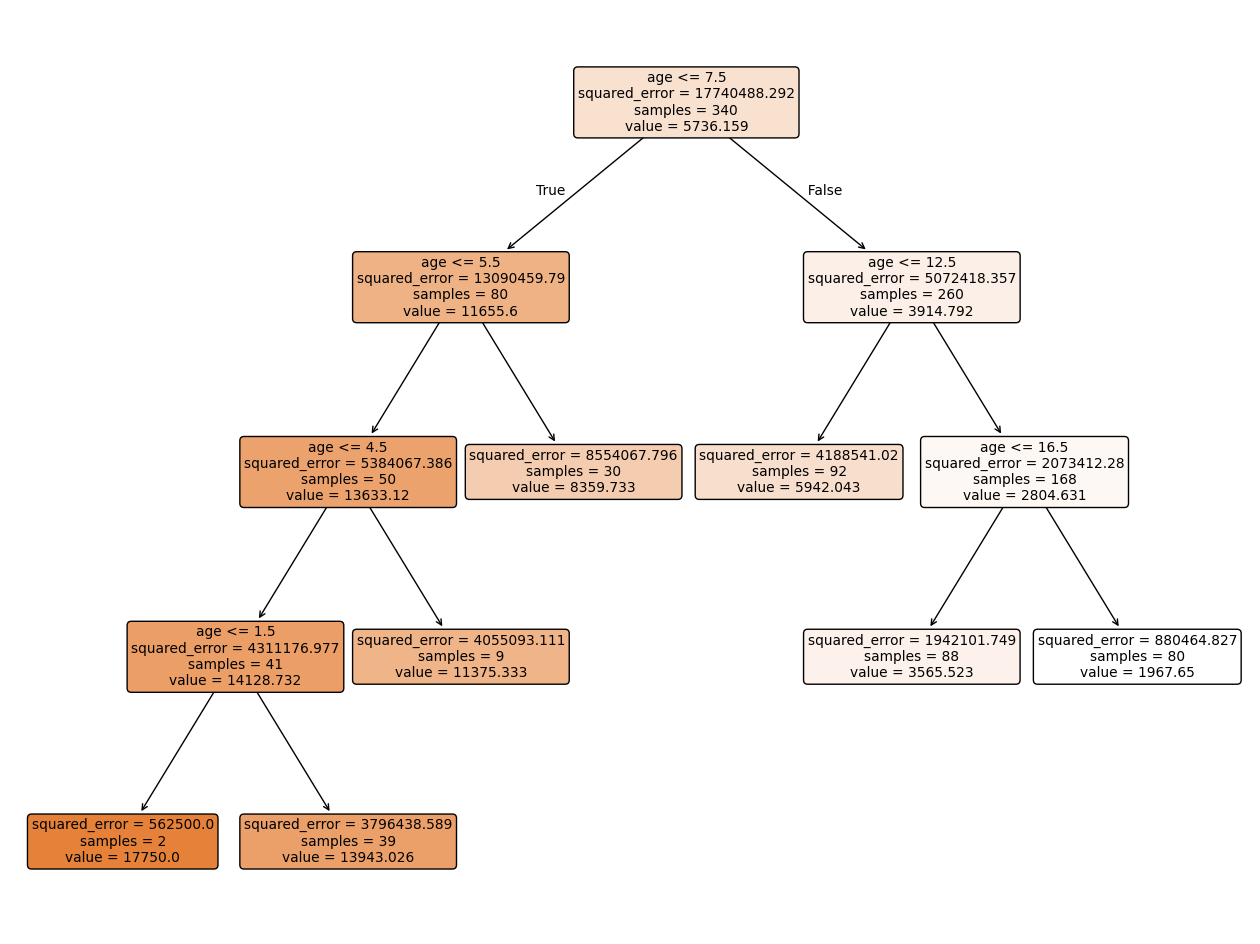

In [47]:
plt.figure(figsize=(16, 12))
plot_tree(cart3, feature_names=["age"], filled=True, rounded=True)
plt.show()

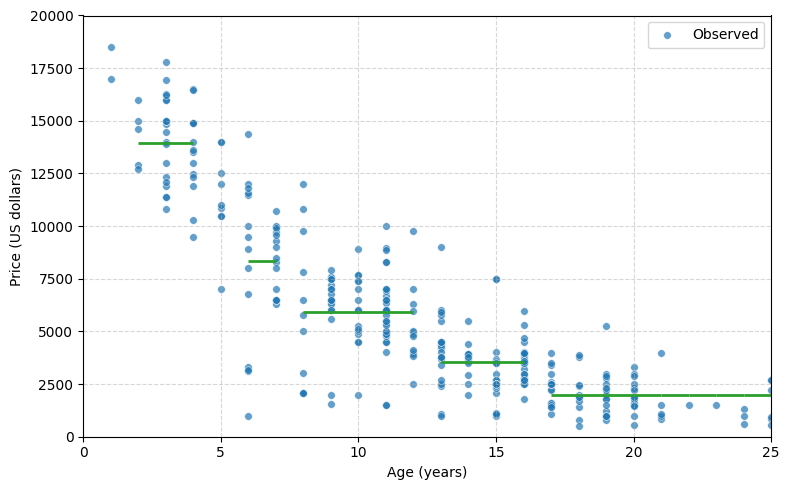

In [48]:
# Seaborn/Matplotlib plot with gaps (no linking lines between steps)
ages = np.arange(data_train["age"].min(), data_train["age"].max() + 1)
preds = cart3.predict(ages.reshape(-1, 1))

plt.figure(figsize=(8, 5))
sns.scatterplot(x="age", y="price", data=data_train, color="tab:blue", s=30, alpha=0.7, label="Observed")

# Plot horizontal lines for each segment, with gaps at splits
for i in range(len(ages) - 1):
    if preds[i] == preds[i + 1]:
        plt.hlines(preds[i], ages[i], ages[i + 1], color="tab:green", linewidth=2, label="Tree prediction (step)" if i == 0 else "")
    else:
        plt.hlines(preds[i], ages[i], ages[i], color="tab:green", linewidth=2)  # just a point, creates a gap

plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.ylim(0, 20000)
plt.xlim(0, 25)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


#### Age only linear regression
---

In [49]:
linreg1 = smf.ols("price~age", data=data_train).fit()
linreg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     785.9
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           3.36e-90
Time:                        18:25:20   Log-Likelihood:                -3115.7
No. Observations:                 340   AIC:                             6235.
Df Residuals:                     338   BIC:                             6243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.329e+04    297.194     44.707      0.000    1.27e+04    1.39e+04
age         -615.0449     21.939    -28.034      0.000    -658.199    -571.891
==============================================================================
Omnibus:                        9.715   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               17.387
Skew:                          -0.081   Prob(JB):                     0.000168
Kurtosis:                       4.096   Cond. No.                         32.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
pred_linreg1 = linreg1.predict(data_test)
rmse_ols1 = np.sqrt(mean_squared_error(data_test["price"], pred_linreg1))
rmse_ols1

np.float64(2258.2934364116545)

In [51]:
## Scatterplot with predicted values
pred_linreg1t = linreg1.predict(data_train)

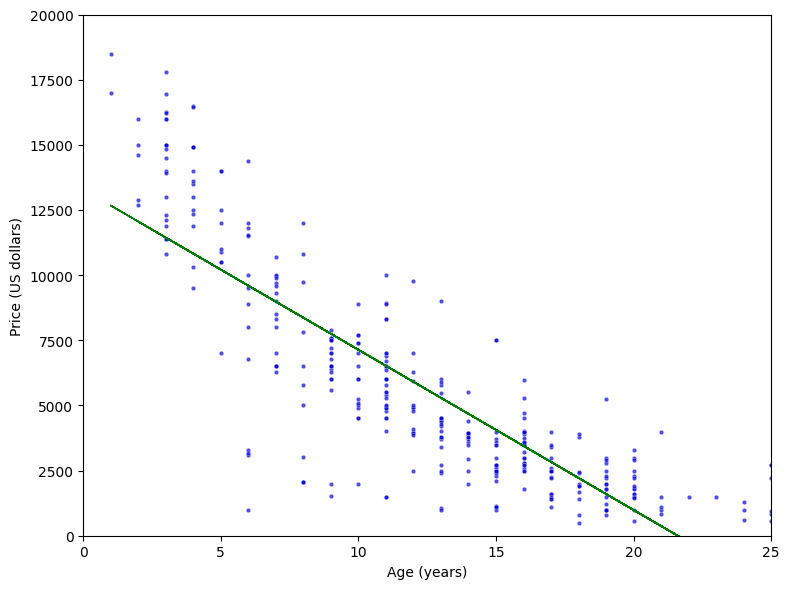

In [52]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_train, x="age", y="price", color="blue", s=10, alpha=0.7, legend=False)
plt.plot(data_train["age"], pred_linreg1t, color="green", linewidth=1)
plt.ylim(0, 20000)
plt.xlim(0, 25)
plt.yticks(np.arange(0, 20001, 2500))
plt.xticks(np.arange(0, 26, 5))
plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.grid(False)
plt.tight_layout()
plt.show()


In [53]:
#### Age only only lowess
lowess = sm.nonparametric.KernelReg

In [54]:
lowess1 = lowess(data_train.price, data_train.age, "c")

In [55]:
pred_lowess1 = lowess1.fit(data_test["age"])
rmse_lowess1 = np.sqrt(mean_squared_error(data_test["price"], pred_lowess1[0]))
pred_lowess1t = lowess1.fit(data_train["age"])

In [56]:
data_lowess = data_train.copy()
data_lowess["pred_lowess1t"] = pred_lowess1t[0]

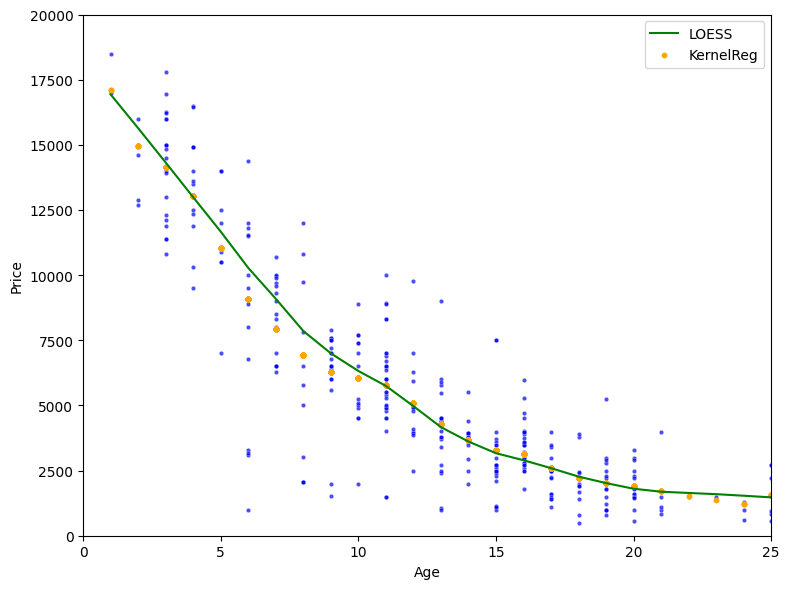

In [57]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_train, x="age", y="price", color="blue", s=10, alpha=0.7, legend=False)

# Loess smoothing line
from statsmodels.nonparametric.smoothers_lowess import lowess
loess_smoothed = lowess(data_train["price"], data_train["age"], frac=0.3)
plt.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], color="green", linewidth=1.5, label="LOESS")

# KernelReg predictions (yellow points)
plt.scatter(data_train["age"], pred_lowess1t[0], color="orange", s=10, label="KernelReg")

plt.xlabel("Age")
plt.ylabel("Price")
plt.xlim(0, 25)
plt.ylim(0, 20000)
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()


### MULTIPLE PREDICTOR VARIABLES

In [58]:
# Linear regression with multiple variables
model2 = "price ~ age + odometer + LE + XLE + SE + cond_excellent + cond_good + cylind6 + dealer + chicago"
linreg2 = smf.ols(model2, data_train).fit()
linreg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     122.1
Date:                Mon, 04 Aug 2025   Prob (F-statistic):          2.31e-104
Time:                        18:25:23   Log-Likelihood:                -3056.5
No. Observations:                 340   AIC:                             6135.
Df Residuals:                     329   BIC:                             6177.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.386e+04    430.556     32.195      0.000     1.3e+04    1.47e+04
age             -391.2949     27.335    -14.315      0.000    -445.068    -337.522
odometer        -265.3642     28.442     -9.330      0.000    -321.315    -209.413
LE              -272.2772    272.591     -0.999      0.319    -808.518     263.964
XLE              142.8662    399.237      0.358      0.721    -642.514     928.246
SE              1105.1213    395.599      2.794      0.006     326.898    1883.345
cond_excellent  -252.8939    399.921     -0.632      0.528   -1039.619     533.831
cond_good       -306.7402    381.699     -0.804      0.422   -1057.619     444.138
cylind6         -723.4701    334.034     -2.166      0.031   -1380.581     -66.359
dealer          1300.0406    300.963      4.320      0.000     707.986    1892.096
chicago          196.5262    230.779      0.852      0.395    -257.463     650.515
==============================================================================
Omnibus:                       15.643   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.511
Skew:                          -0.144   Prob(JB):                     1.94e-08
Kurtosis:                       4.557   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
data.columns

Index(['index', 'area', 'subarea', 'name', 'condition', 'cylinders', 'drive',
       'fuel', 'odometer', 'paintcolor', 'size', 'transmission', 'type',
       'dealer', 'price', 'lnprice', 'year', 'age', 'lnodometer', 'LE', 'XLE',
       'SE', 'Hybrid', 'cond_excellent', 'cond_good', 'cond_likenew',
       'cylind6', 'chicago', 'agesq', 'agecu', 'odometersq', 'train'],
      dtype='object')

In [60]:
pred_linreg2 = linreg2.predict(data_test)
rmse_linreg2 = np.sqrt(mean_squared_error(data_test["price"], pred_linreg2))
rmse_linreg2

np.float64(1725.1841750420692)

In [61]:
# add squared for age, odometer
model3 = "price ~ age + agesq+ odometer+odometersq +LE + XLE + SE + cond_excellent + cond_good + cylind6 + dealer+chicago"
linreg3 = smf.ols(model3, data_train).fit()
linreg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     168.2
Date:                Mon, 04 Aug 2025   Prob (F-statistic):          6.26e-132
Time:                        18:25:23   Log-Likelihood:                -2985.0
No. Observations:                 340   AIC:                             5996.
Df Residuals:                     327   BIC:                             6046.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.741e+04    447.397     38.908      0.000    1.65e+04    1.83e+04
age             -994.3673     78.026    -12.744      0.000   -1147.864    -840.871
agesq             23.5447      2.628      8.958      0.000      18.374      28.715
odometer        -381.1126     42.717     -8.922      0.000    -465.148    -297.077
odometersq         0.2074      0.042      4.988      0.000       0.126       0.289
LE               139.0098    223.840      0.621      0.535    -301.339     579.359
XLE                9.9274    324.778      0.031      0.976    -628.991     648.846
SE               798.5548    325.805      2.451      0.015     157.617    1439.493
cond_excellent   195.2455    327.211      0.597      0.551    -448.458     838.949
cond_good       -128.7248    310.624     -0.414      0.679    -739.799     482.350
cylind6         -300.2805    274.075     -1.096      0.274    -839.454     238.893
dealer           882.0680    246.786      3.574      0.000     396.580    1367.556
chicago          377.6063    189.183      1.996      0.047       5.438     749.775
==============================================================================
Omnibus:                       70.368   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.083
Skew:                          -0.838   Prob(JB):                     8.28e-60
Kurtosis:                       7.050   Cond. No.                     3.22e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
pred_linreg3 = linreg3.predict(data_test)
rmse_linreg3 = np.sqrt(mean_squared_error(data_test["price"], pred_linreg3))
rmse_linreg3

np.float64(1432.2606558031277)

In [63]:
Y, X = dmatrices(model2, data_train)

In [64]:
# Tree

# Splits at four levels, for illustrative purposes
# (make sure it stops by setting "maxdepth" to 3)
cart4 = DecisionTreeRegressor(random_state=20108, criterion="squared_error", max_depth=3)
cart4.fit(X, Y)

DecisionTreeRegressor(max_depth=3, random_state=20108)

In [65]:
y_test, X_test = dmatrices(model2, data_test)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = np.sqrt(mean_squared_error(y_test, pred_cart4))
rmse_cart4

np.float64(1774.7722307832048)

In [66]:
feature_names_model2 = [
    "price",
    "age",
    "odometer",
    "LE",
    "XLE",
    "SE",
    "cond_excellent",
    "cond_good",
    "cylind6",
    "dealer",
    "chicago",
]

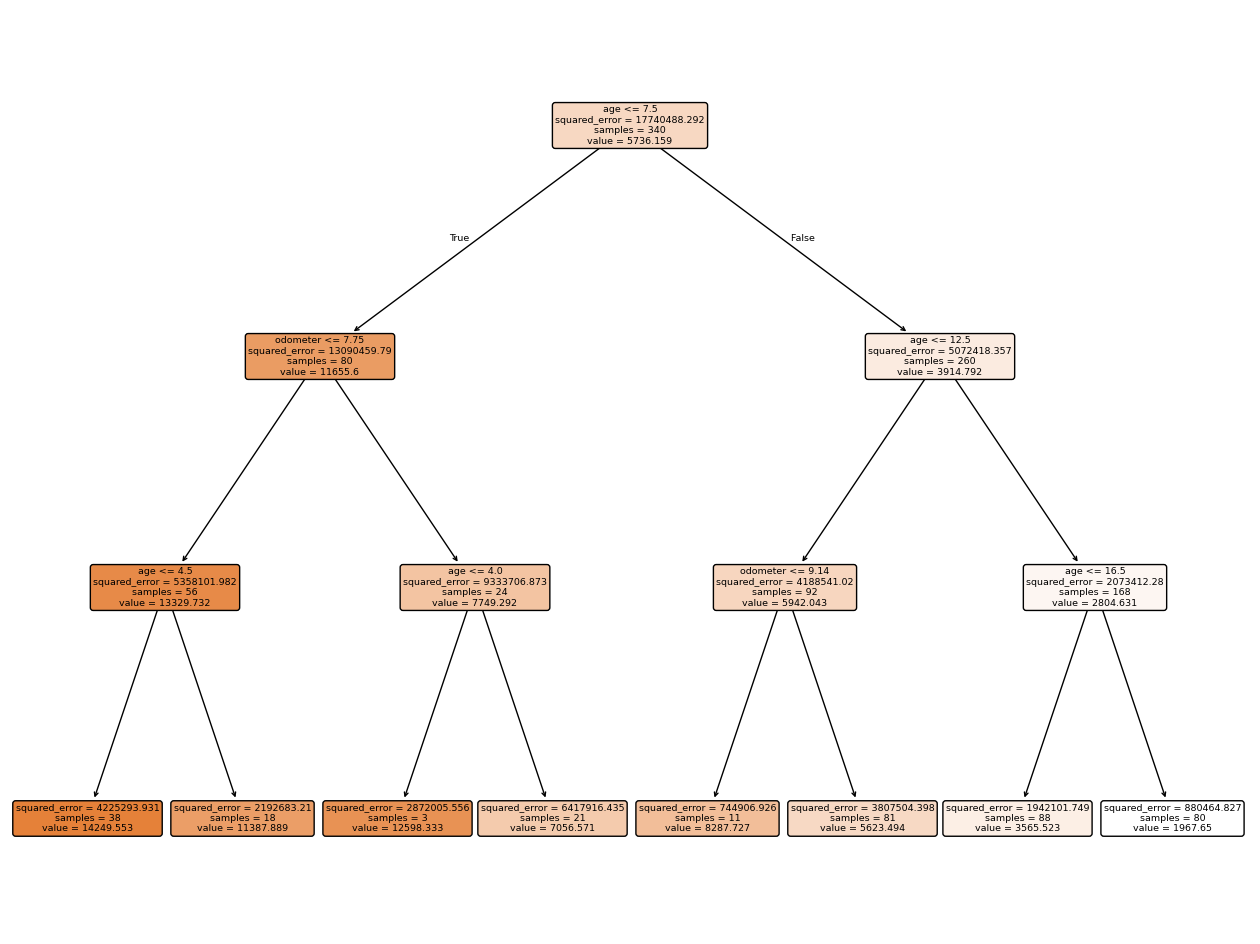

In [67]:
plt.figure(figsize=(16, 12))
plot_tree(cart4, feature_names=feature_names_model2, filled=True, rounded=True)
plt.show()

In [68]:
# alternative to show the use of min_impurity_decrease
# slightly the same outcome

In [69]:
cart4 = DecisionTreeRegressor(
    random_state=20108,
    criterion="squared_error",
    min_impurity_decrease=145000,
    min_samples_split=28,
)
cart4.fit(X, Y)

y_test, X_test = dmatrices(model2, data_test)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = np.sqrt(mean_squared_error(y_test, pred_cart4))
rmse_cart4


np.float64(1765.7421815906253)

In [70]:
print(set(cart4.tree_.threshold))

{np.float64(4.5), np.float64(7.75), np.float64(7.5), np.float64(9.139999866485596), np.float64(12.5), np.float64(16.5), np.float64(-2.0)}


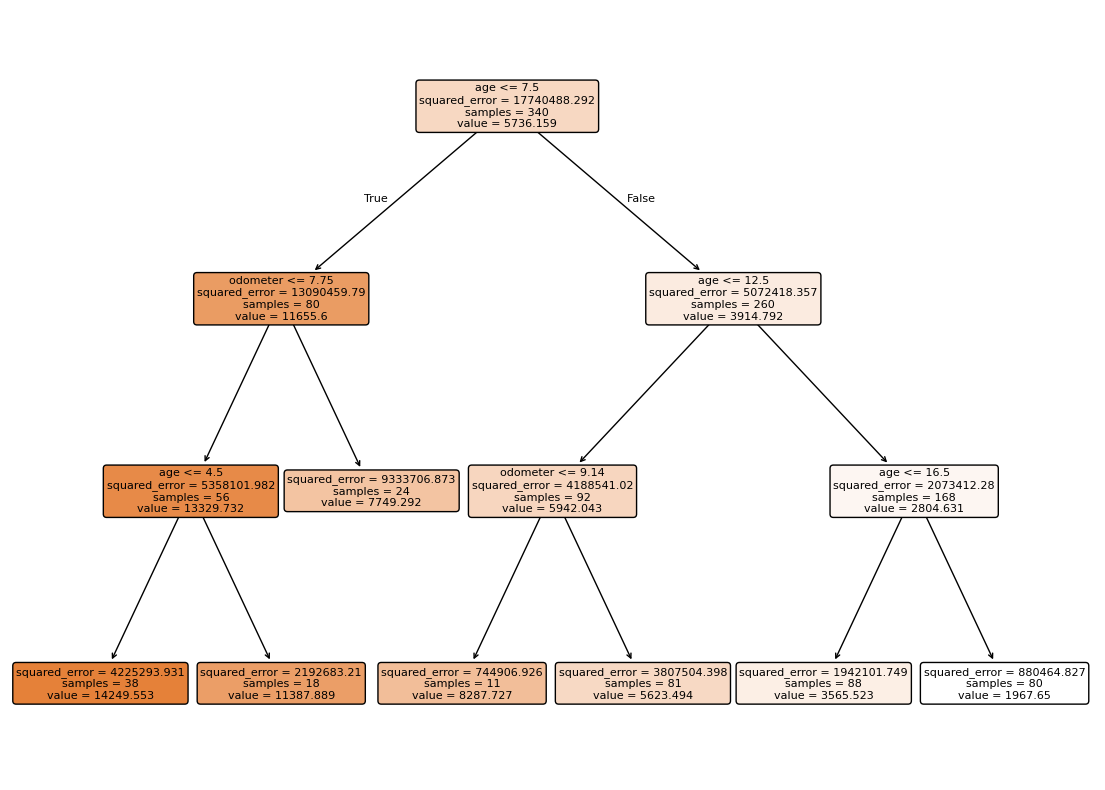

In [71]:
plt.figure(figsize=(14, 10))
plot_tree(cart4, feature_names=feature_names_model2, filled=True, rounded=True)
plt.show()

In [72]:
# CART M5
cart5 = DecisionTreeRegressor(
    random_state=20108,
    criterion="squared_error",
    min_impurity_decrease=20000,
)
cart5.fit(X, Y)


DecisionTreeRegressor(min_impurity_decrease=20000, random_state=20108)

In [73]:
pred_cart5 = cart5.predict(X_test)
rmse_cart5 = np.sqrt(mean_squared_error(y_test, pred_cart5))
rmse_cart5

np.float64(1794.290503991125)

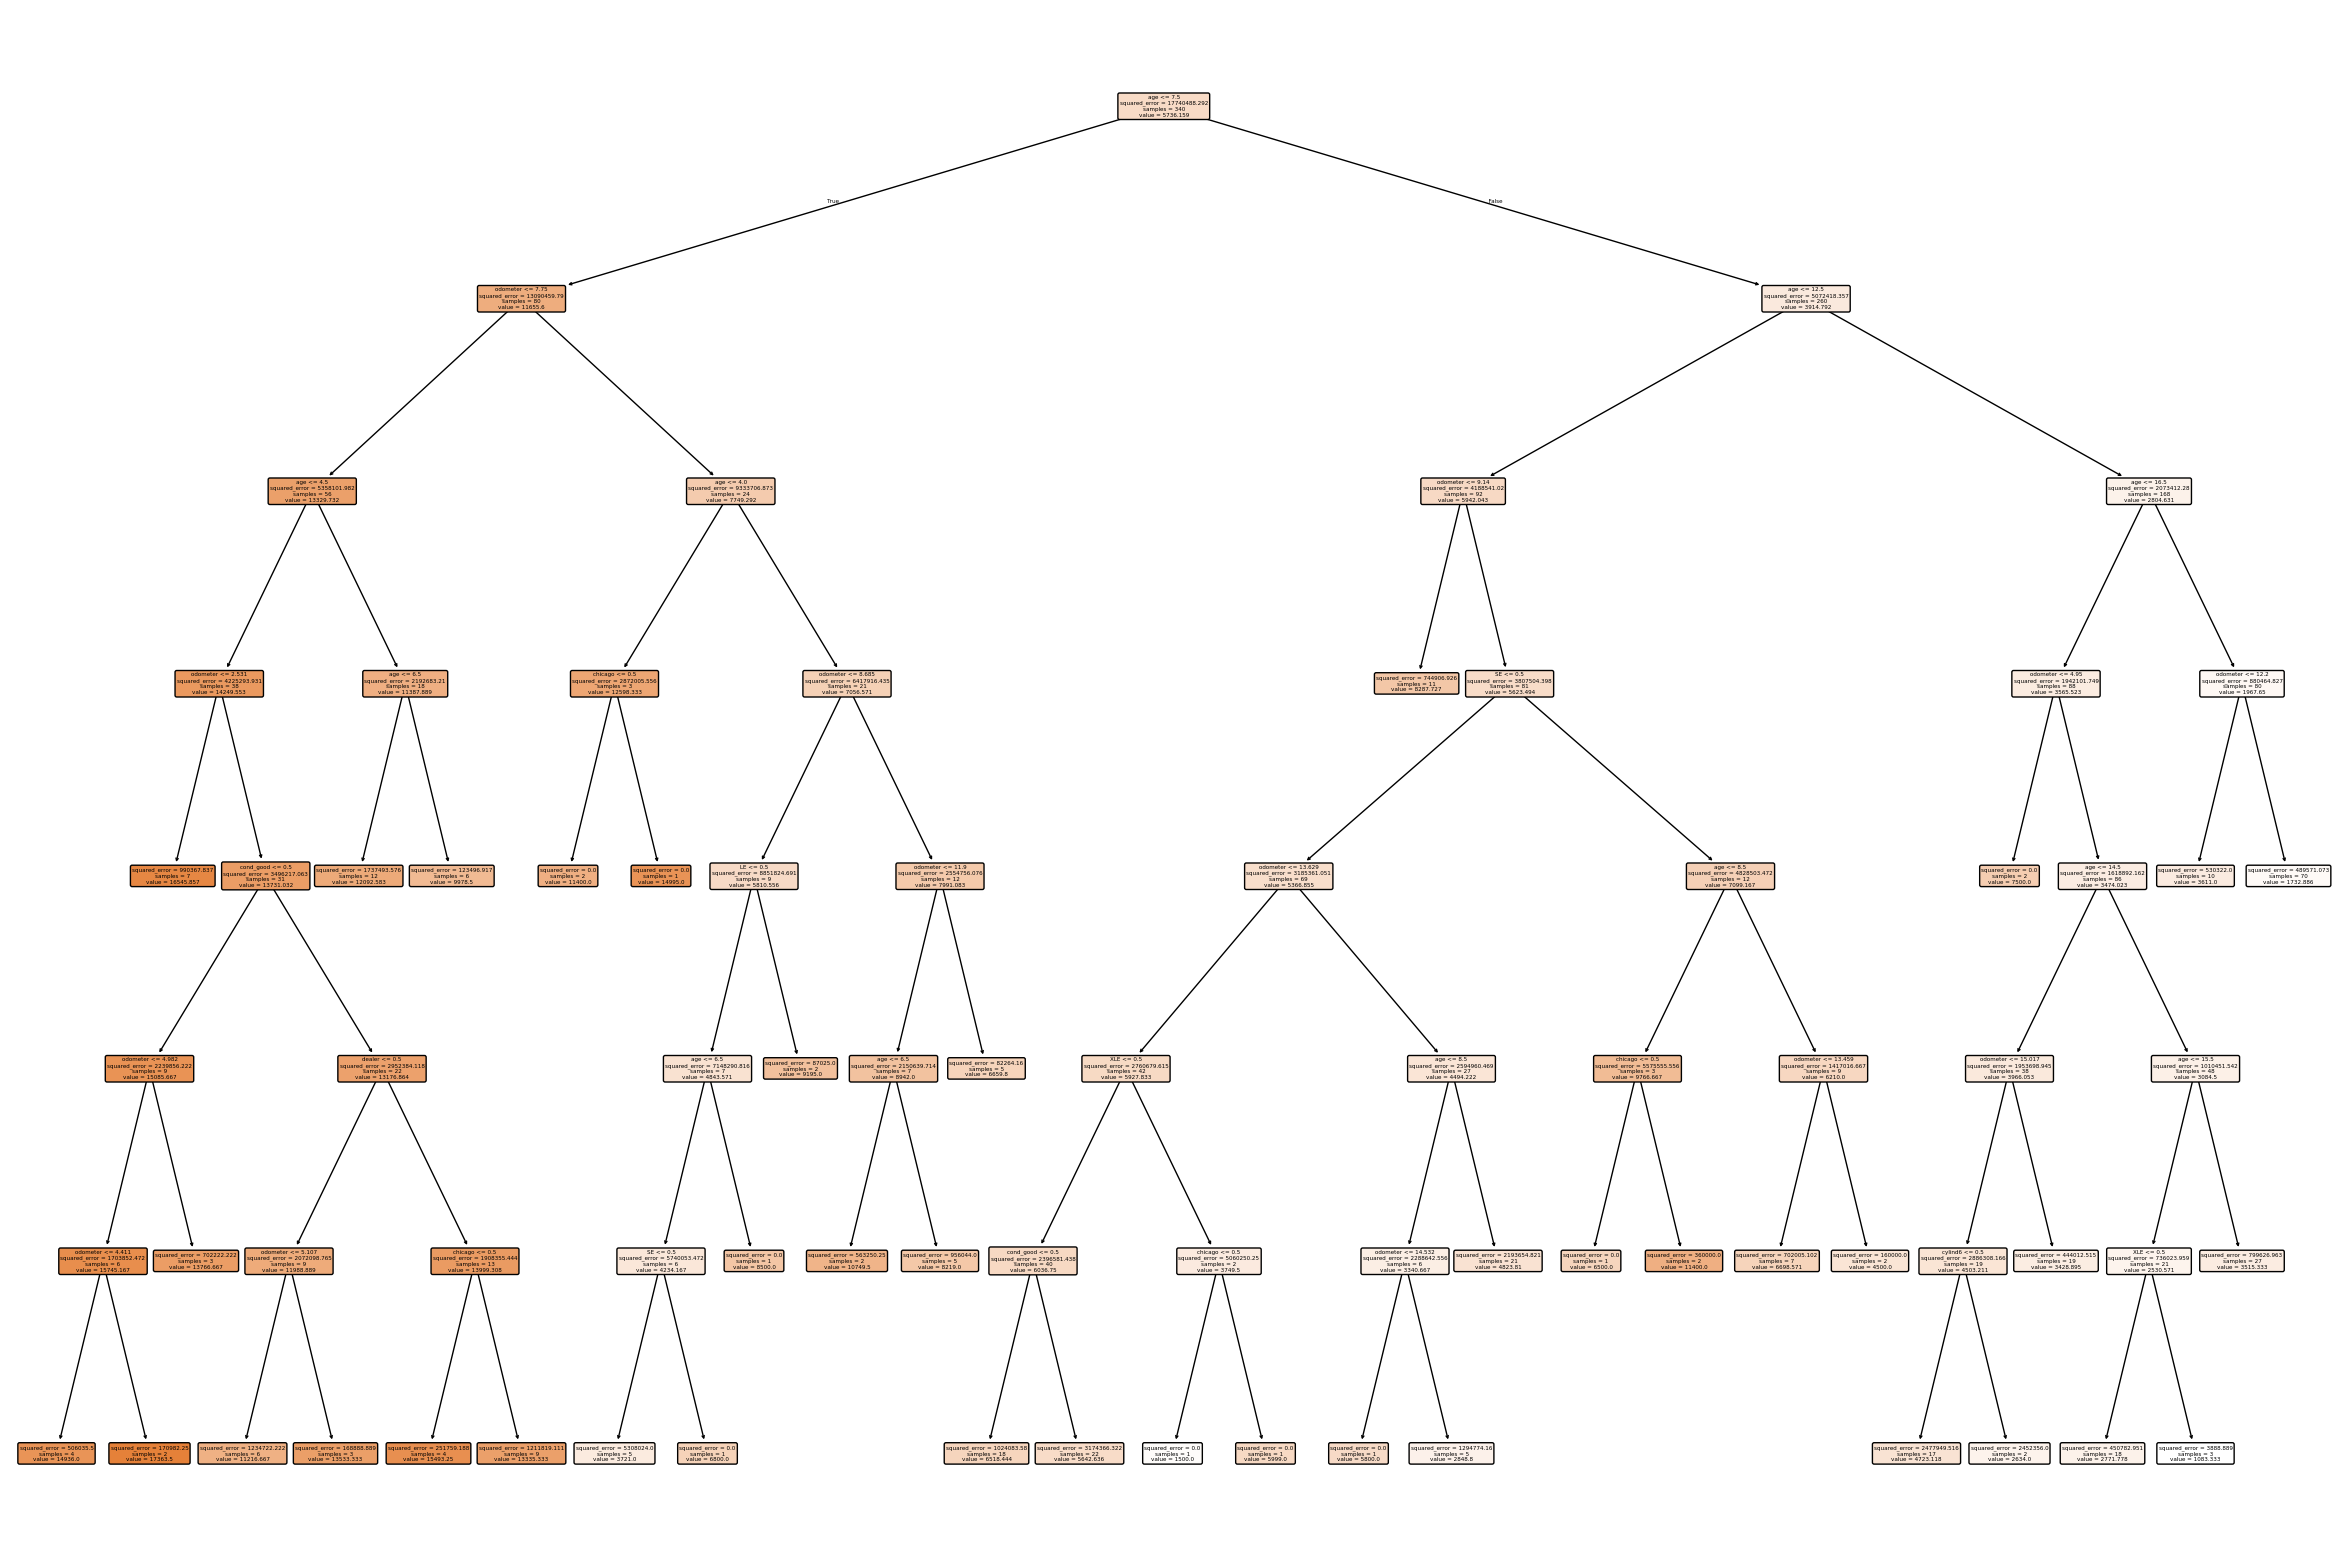

In [74]:
plt.figure(figsize=(30, 20))
plot_tree(cart5, feature_names=feature_names_model2, filled=True, rounded=True)
plt.show()

In [75]:
# build very large tree and prune it
# in Python this can be done in sklearn's DecisionTreeRegressor with ccp_alpha parameter
cart6 = DecisionTreeRegressor(
    random_state=20108, min_samples_split=4, criterion="squared_error", ccp_alpha=30000
)
cart6.fit(X, Y)


DecisionTreeRegressor(ccp_alpha=30000, min_samples_split=4, random_state=20108)

In [76]:
pred_cart6 = cart6.predict(X_test)
rmse_cart6 = np.sqrt(mean_squared_error(y_test, pred_cart6))
rmse_cart6

np.float64(1846.6721057114366)

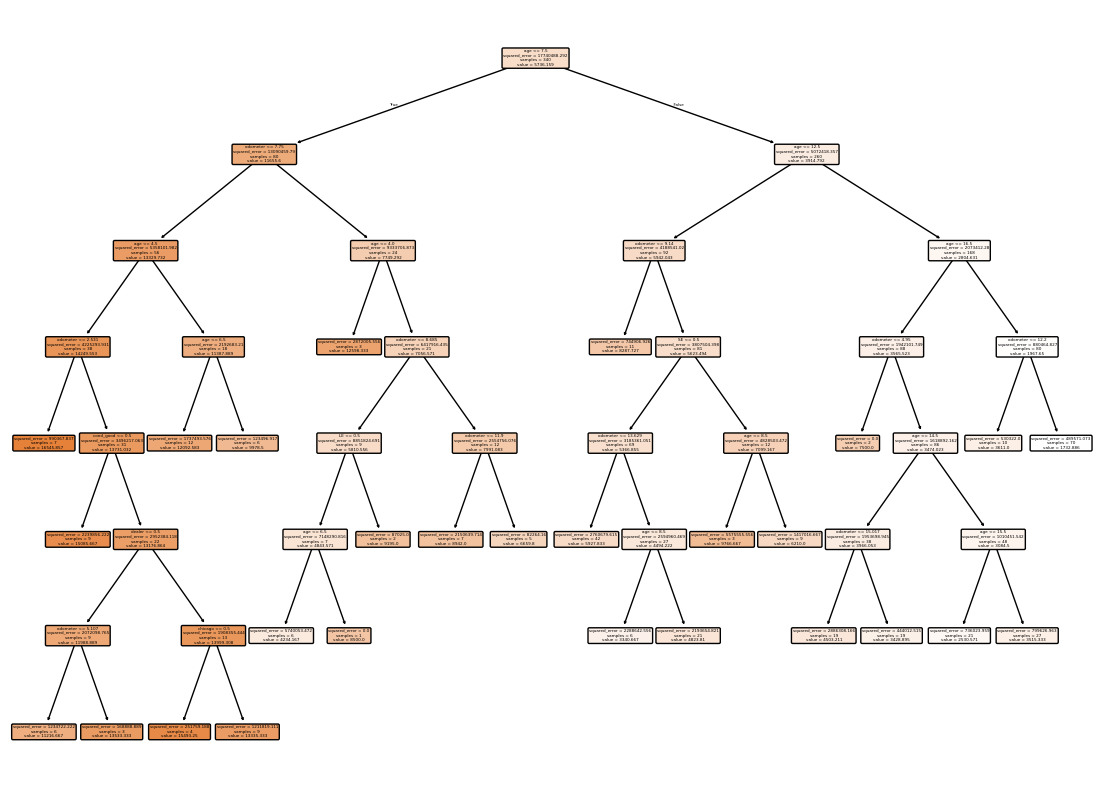

In [77]:
plt.figure(figsize=(14, 10))
plot_tree(cart6, feature_names=feature_names_model2, filled=True, rounded=True)
plt.show()

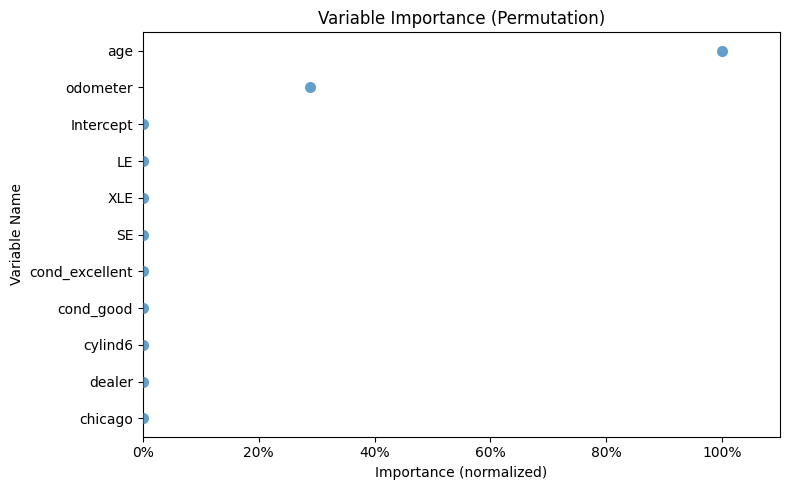

In [79]:
# Compute permutation importance for cart4
perm_importance = permutation_importance(cart4, X, Y.ravel(), n_repeats=30, random_state=42)
cart4_var_imp_df = pd.DataFrame({
    "index": X.design_info.column_names,
    "Importance": perm_importance.importances_mean / perm_importance.importances_mean.max()
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.stripplot(
    data=cart4_var_imp_df,
    y="index",
    x="Importance",
    color="tab:blue",
    size=8,
    alpha=0.7,
    orient="h"
)
plt.xlabel("Importance (normalized)")
plt.ylabel("Variable Name")
plt.xlim(0, cart4_var_imp_df["Importance"].max() * 1.1)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
plt.title("Variable Importance (Permutation)")
plt.tight_layout()
plt.show()


In [80]:
pd.DataFrame(
    {
        "Model": ["CART M" + str(i) for i in range(1, 7)]
        + ["OLS M" + str(i) for i in range(1, 4)],
        "Number of variables": [1, 1, 7, 7, 7, 7, 1, 7, 7],
        "Model details": [
            "2 levels",
            "3 levels",
            "min_impurity_decrease=50000",
            "min_impurity_decrease=140000 & min_samples_split=20",
            "min_impurity_decrease=20000",
            "ccp_alpha=30000",
            "linear",
            "linear",
            "w/ polynomial terms",
        ],
        "RMSE": [
            rmse_cart1,
            rmse_cart2,
            rmse_cart3,
            rmse_cart4,
            rmse_cart5,
            rmse_cart6,
            rmse_ols1,
            rmse_linreg2,
            rmse_linreg3,
        ],
    }
).set_index("Model")


,Number of variables,Model details,RMSE
Model,,,
CART M1,1,2 levels,2665.414283
CART M2,1,3 levels,2030.614610
CART M3,7,min_impurity_decrease=50000,1885.919546
CART M4,7,min_impurity_decrease=140000 & min_samples_spl...,1765.742182
CART M5,7,min_impurity_decrease=20000,1794.290504
CART M6,7,ccp_alpha=30000,1846.672106
OLS M1,1,linear,2258.293436
OLS M2,7,linear,1725.184175
OLS M3,7,w/ polynomial terms,1432.260656


### LASSO

In [92]:
data_new = data.copy()

In [96]:
data_new.shape

(487, 32)

In [98]:
data_new

,index,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,Hybrid,cond_excellent,cond_good,cond_likenew,cylind6,chicago,agesq,agecu,odometersq,train
0,0,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.623600,grey,...,1,0,1,0,0,1,121,1331,1570.442243,1
1,2,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,Missing,gas,3.572100,NaN,...,0,1,0,0,0,1,9,27,45.579633,1
2,3,chicago,chicago city,2016 TOYOTA CAMRY,good,Missing,fwd,gas,1.315200,NaN,...,0,0,1,0,0,1,4,8,2.274969,0
3,4,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,...,0,0,1,0,1,1,625,15625,6539.203000,1
4,6,chicago,chicago city,1998 toyota camry le,good,Missing,Missing,gas,16.824259,NaN,...,0,0,1,0,0,1,400,8000,4762.202089,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,543,los angeles,North LA county,2001 toyota camry,excellent,6 cylinders,Missing,gas,27.000000,NaN,...,0,1,0,0,1,0,289,4913,19683.000000,1
483,545,los angeles,central LA,2012 toyota camry se,excellent,4 cylinders,Missing,gas,8.304974,NaN,...,0,1,0,0,0,0,36,216,572.815510,1
484,546,los angeles,central LA,2008 TOYOTA CAMRY,good,Missing,Missing,gas,12.548112,NaN,...,0,0,1,0,0,0,100,1000,1975.764375,1
485,547,los angeles,San Fernando,2002 toyota camry,excellent,4 cylinders,Missing,gas,16.100000,NaN,...,0,1,0,0,0,0,256,4096,4173.281000,1


In [102]:
data_new = data_new.replace("Missing", np.nan)
data_new.isna().sum()

index               0
area                0
subarea             9
name                0
condition           0
cylinders         172
drive             238
fuel                0
odometer            0
paintcolor        214
size              320
transmission        0
type              227
dealer              0
price               0
lnprice             0
year                0
age                 0
lnodometer          0
LE                  0
XLE                 0
SE                  0
Hybrid              0
cond_excellent      0
cond_good           0
cond_likenew        0
cylind6             0
chicago             0
agesq               0
agecu               0
odometersq          0
train               0
dtype: int64

In [106]:
data_new.dropna(inplace=True)
data_new.isna().sum()

index             0
area              0
subarea           0
name              0
condition         0
cylinders         0
drive             0
fuel              0
odometer          0
paintcolor        0
size              0
transmission      0
type              0
dealer            0
price             0
lnprice           0
year              0
age               0
lnodometer        0
LE                0
XLE               0
SE                0
Hybrid            0
cond_excellent    0
cond_good         0
cond_likenew      0
cylind6           0
chicago           0
agesq             0
agecu             0
odometersq        0
train             0
dtype: int64

In [108]:
data_new.shape

(125, 32)

In [109]:
data_new

,index,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,Hybrid,cond_excellent,cond_good,cond_likenew,cylind6,chicago,agesq,agecu,odometersq,train
3,4,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.70000,red,...,0,0,1,0,1,1,625,15625,6539.203000,1
7,9,chicago,chicago city,2000 toyota camry le,excellent,4 cylinders,fwd,gas,10.70000,white,...,0,1,0,0,0,1,324,5832,1225.043000,0
13,15,chicago,chicago city,2005 toyota camry LE,excellent,6 cylinders,4wd,gas,12.04510,grey,...,0,1,0,0,1,1,169,2197,1747.556516,1
14,17,chicago,chicago city,2007 toyota camry,good,4 cylinders,fwd,gas,11.62693,silver,...,0,0,1,0,0,1,121,1331,1571.792456,1
19,22,chicago,chicago city,2009 toyota camry se 4dr sedan,excellent,4 cylinders,fwd,gas,11.33000,grey,...,0,1,0,0,0,1,81,729,1454.419637,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,518,los angeles,San Fernando,1992 Toyota Camry,good,4 cylinders,fwd,gas,16.80000,grey,...,0,0,1,0,0,0,676,17576,4741.632000,1
467,525,los angeles,central LA,2004 toyota camry,good,4 cylinders,fwd,gas,11.60000,silver,...,0,0,1,0,0,0,196,2744,1560.896000,1
477,536,los angeles,LA long beach,2003 toyota camry,good,4 cylinders,fwd,gas,16.20000,black,...,0,0,1,0,0,0,225,3375,4251.528000,1
479,539,los angeles,central LA,1999 toyota camry,excellent,4 cylinders,fwd,gas,12.40000,white,...,0,1,0,0,0,0,361,6859,1906.624000,1


In [114]:
data_new.drop("name", axis=1, inplace=True)

KeyError: "['name'] not found in axis"

In [111]:
data_new.dtypes

index               int64
area               object
subarea            object
name               object
condition          object
cylinders          object
drive              object
fuel               object
odometer          float64
paintcolor         object
size               object
transmission       object
type               object
dealer              int64
price               int64
lnprice           float64
year                int64
age                 int64
lnodometer        float64
LE                  int64
XLE                 int64
SE                  int64
Hybrid              int64
cond_excellent      int64
cond_good           int64
cond_likenew        int64
cylind6             int64
chicago             int64
agesq               int64
agecu               int64
odometersq        float64
train               int64
dtype: object

In [ ]:
dummies = pd.get_dummies(data_new[["area", "subarea", "fuel", "color"]], prefix=["area", "fuel", "color"])
data_new = pd.concat([data_new, dummies], axis=1)

In [84]:
# Define predictors (all except 'price')
features = [col for col in data_train.columns if col != 'price']

# Train
X_train = data_train[features]
y_train = data_train["price"]

# Test
X_test = data_test[features]
y_test = data_test["price"]

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ValueError: could not convert string to float: 'chicago'